# dbdia notebook

Author: __[Eduardo R. B. Marques](https://www.dcc.fc.up.pt/~edrdo), DCC/FCUP__

This Colab notebook lets you run __[dbdia](https://github.com/edrdo/dbdia)__ with a visual user interface.


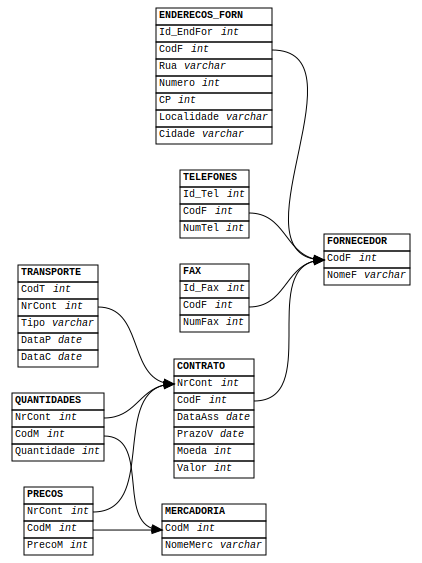

HTML(value='<b>Command output</b>')

HTML(value='\n<b> ==> Running dbdia 0.5</b><br/>\n<b> $ dbdia-0.5/bin/dbdia  sch MyDiagram.er MyDiagram.svg</b…

In [1]:
#@title  <b>&larr; click "play" button</b>
import os
import subprocess
import time
import html
import google.colab
from ipywidgets import widgets, Layout
from IPython.display import display, clear_output
from IPython.display import Image, HTML, SVG

class U: 
  def clear():
   UI.commandOutput.value = ''
  def showHtml(x):
    UI.commandOutput.value = UI.commandOutput.value + "\n" + x
  def msg(x):
    U.showHtml('<b> ' + x + '</b><br/>')
  def shell(cmd):
    U.msg('$ ' + cmd)
    ret = subprocess.run(cmd, shell=True, universal_newlines=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    U.showHtml('<pre>' + html.escape(ret.stdout) + '</pre>')
    if ret.returncode == 0: 
      U.msg('[ok]')
    else:
      U.msg('[there was an error]')
    return ret.returncode == 0

class dbdia:
  VERSION = '0.5'
  HOME = 'dbdia-' + VERSION
  PROGRAM = HOME + '/bin/dbdia'
  RELEASE_ZIP = HOME + '-release.zip'
  RELEASE_URL = 'https://github.com/edrdo/dbdia/releases/download/' + VERSION + '/' + RELEASE_ZIP + '?dl=1'

  def setup(force=False):
    ready = True
    if force or (not os.access(dbdia.HOME, os.R_OK)):
      U.msg('==> Setting up dbdia ' + dbdia.VERSION)
      ready = U.shell('rm -fr ' + dbdia.RELEASE_ZIP + ' ' + dbdia.HOME) and \
              U.shell('curl -Ls ' + dbdia.RELEASE_URL + ' -o ' + dbdia.RELEASE_ZIP) and \
              U.shell('unzip -q -o ' + dbdia.RELEASE_ZIP) and \
              dbdia.version()
      if not ready:
        U.msg('Could not install dbdia')
    return ready

  def version():
    return U.shell(dbdia.PROGRAM + ' version')

  def help():
    return U.shell(dbdia.PROGRAM + ' help')

  def run(diagramType, inputFile, outputFile, options):
    if not dbdia.setup(force=False):
      return False
    U.msg('==> Running dbdia ' + dbdia.VERSION)
    if os.access(outputFile, os.R_OK):
      os.unlink(outputFile)
    b = U.shell('%s %s %s %s %s' % (dbdia.PROGRAM,
                                options,
                                diagramType,
                                inputFile,
                                outputFile)) 
    if b:
      b = os.access(outputFile, os.R_OK)
      if not b:
        U.msg('dot generated no output file!<br>Is the diagram empty or did you choose the wrong diagram type?')
    return b
    
class UI:  
  # Initialization values 
  INITIAL_INPUT_FILENAME = 'MyDiagram.er'
  INITIAL_FORMAT = 'svg'  
  INITIAL_DIAGRAM_TYPE = 'er'                            
  # input text areea
  inputTextArea = widgets.Textarea(
    value='',
    layout= Layout(width='600px', height='600px'),
    continous_update=True
  )
  # Diagram type selection
  typeOfDiagram = widgets.Dropdown(
    options=[('Relational schema', 'sch'),
             ('ER :: full', 'er'), 
             ('ER :: entities only', 'ent'), 
             ('ER :: relationships only', 'rel')],
    value=INITIAL_DIAGRAM_TYPE,
    description='Type:'
  )
  # Output format selection

  outputFormat = widgets.Dropdown(
    options=[('SVG','svg'), ('PNG','png'), ('PDF','pdf'), ('Dot file only','none')],
    value=INITIAL_FORMAT,
    description='Format:'
  )
  # Output format selection
  INITIAL_EXAMPLE = 'SocialNetwork.er'
  examples = widgets.Dropdown(
    options=[('ER - Entities','Entity.er'), 
             ('ER - Relationships','Relationships.er'), 
             ('ER - Weak entities','WeakEntities.er'), 
             ('Schema - basic example', 'Schema.sch'),
             ('Social Network - ER', 'SocialNetwork.er'),
             ('Social Network - Schema', 'SocialNetwork.sch'),
             ('Social Network 2 - ER', 'SocialNetwork2.er'),
             ('Social Network 2 - Schema', 'SocialNetwork2.sch'),
             ('MovieStream schema', 'MovieStream.sch')
             ],
    value=INITIAL_EXAMPLE,
    description='Examples:'
  )
  loadExample = widgets.Button(description='Load example')
  # File name text widget
  inputFile = widgets.Text(value=INITIAL_INPUT_FILENAME,description='File name:')
  # Output file name text widget
  outputFile = widgets.Text(value='',description='File name:')
  # Generate button
  generate = widgets.Button(description='Generate')
  # Upload button
  upload = widgets.Button(description='Upload')
  # Save input button
  saveInput = widgets.Button(description='Download')
  # Save output button
  saveOutput = widgets.Button(description='Download')
  # Restore defaults button
  defaults = widgets.Button(description='Reset')
  # Options text widget
  options = widgets.Text(description='Options:', layout=Layout(width='300px'))
  # Version button
  version = widgets.Button(description='Version info')
  # help button
  help = widgets.Button(description='dbdia options')
  # Version button
  reinstall = widgets.Button(description='Re-install dbdia')
  # No output text widget
  noOutputLabel = widgets.Label(value='None')
  # last output
  lastOutput = noOutputLabel
  # output widget
  outW = widgets.Output()
  # Initialized flag
  initialized = False
  # Command output
  commandOutput = widgets.HTML(value='')
  
  def init():
    if UI.initialized:
      return 
    UI.generate.on_click(UI.onGenerate)
    UI.upload.on_click(UI.onUpload)
    UI.saveInput.on_click(UI.onSaveInput)
    UI.saveOutput.on_click(UI.onSaveOutput)
    UI.defaults.on_click(UI.onRestoreDefaults)
    UI.help.on_click(UI.onHelp)
    UI.version.on_click(UI.onVersion)
    UI.reinstall.on_click(UI.onReinstall)
    UI.loadExample.on_click(UI.onLoadExample)
    UI.outputFormat.on_trait_change(lambda _: UI.updateOutputFileName(False))
    UI.inputFile.on_trait_change(UI.onInputFileChange)
    UI.initialized = True
    UI.reset()

  def reset():
    UI.typeOfDiagram.value = UI.INITIAL_DIAGRAM_TYPE
    UI.outputFormat.value = UI.INITIAL_FORMAT
    UI.inputFile.value = UI.INITIAL_INPUT_FILENAME
    UI.lastInput = UI.noOutputLabel
    UI.inputTextArea.value = ''
    UI.updateOutputFileName(True)
    UI.commandOutput.value = ''

  def draw():
    UI.init()
    clear_output()
    UI.outW.clear_output()
    display(UI.outW)
    # time.sleep(1)
    with UI.outW:
      clear_output()
      display(widgets.VBox([ 
              widgets.HTML('<b>ER or relational model</b>'),
              widgets.HBox([
                 UI.inputTextArea,
                 widgets.VBox([ 
                    widgets.HTML('<b>Model</b>'),
                    UI.inputFile,
                    UI.upload, 
                    UI.saveInput, 
                    UI.defaults,
                    UI.examples,
                    UI.loadExample,
                    widgets.HTML('<b>Diagram</b>'),
                    UI.outputFile,
                    UI.typeOfDiagram, 
                    UI.outputFormat,
                    UI.options,
                    UI.generate,
                    UI.saveOutput,
                    widgets.HTML('<b>dbdia</b>'),
                    UI.version,
                    UI.help,
                    UI.reinstall])]),
              widgets.HTML('<b>Diagram</b>')]),
              UI.lastOutput,
              widgets.HTML('<b>Command output</b>'),
              UI.commandOutput)
    #display(UI.outW)

  def onInputFileChange():
    if UI.inputFile.value.endswith('.sch'): 
      UI.typeOfDiagram.value = 'sch'
    elif UI.typeOfDiagram.value == 'sch':
      UI.typeOfDiagram.value = 'er'
  
  def saveInputToFile():
    with open(UI.inputFile.value, 'wb') as out:
      out.write(UI.inputTextArea.value.encode('utf-8'))

  def updateOutputFileName(force):
    if UI.outputFormat.value == 'none':
      ext = '.dot'
    else:
      ext = '.' + UI.outputFormat.value
    if force or not UI.outputFile.value.endswith(ext):
      f, _ = os.path.splitext(UI.inputFile.value)
      UI.outputFile.value = f + ext

  def onRestoreDefaults(b):
    UI.reset()
    UI.draw()

  def onVersion(b):
    UI.commandOutput.value=''
    dbdia.version() and \
    U.shell('java --version') and \
    U.shell('dot -V')  
    UI.draw()

  def onHelp(b):
    UI.commandOutput.value=''
    dbdia.help()
    UI.draw()
    
  
  def onReinstall(b):
    UI.commandOutput.value=''
    dbdia.setup(force=True)
    UI.draw()

  def onGenerate(b):
    UI.updateOutputFileName(False)
    UI.saveInputToFile()
    UI.commandOutput.value=''
    ok = dbdia.run(UI.typeOfDiagram.value,
                   UI.inputFile.value,
                   UI.outputFile.value,
                   UI.options.value)
    if not ok:
      UI.lastOutput = UI.noOutputLabel
    elif UI.outputFormat.value == 'png':
      UI.lastOutput = Image(filename=UI.outputFile.value, format='png')
    elif UI.outputFormat.value == 'svg':
      UI.lastOutput = SVG(filename=UI.outputFile.value)
    elif UI.outputFormat.value == 'pdf':
      UI.lastOutput = widgets.Label('Cannot display PDF file here. Download it.')
    elif UI.outputFormat.value == 'none':
      with open(UI.outputFile.value,'rb') as inp:
        UI.lastOutput = widgets.Textarea(value=inp.read().decode('utf-8'),
                                        layout=Layout(width='480px', height='480px'))
    UI.draw()

  def onUpload(b):
    clear_output()
    U.clear()
    #U.header('Upload model file')
    uploaded = google.colab.files.upload()
    for fn in uploaded.keys():
      UI.inputTextArea.value = uploaded[fn].decode('utf-8')
      UI.inputFile.value = fn
      UI.saveInputToFile()
    UI.onInputFileChange()
    UI.updateOutputFileName(force=True)
    UI.lastOutput = UI.noOutputLabel
    UI.draw()
  
  def onLoadExample(b):
    with open(dbdia.HOME + '/examples/' + UI.examples.value,'rb') as inp:
       UI.inputTextArea.value = inp.read().decode('utf-8')
    UI.inputFile.value = UI.examples.value
    UI.outputFile.value = ''
    UI.onInputFileChange()
    UI.updateOutputFileName(force=True)
    UI.lastOutput = UI.noOutputLabel
    UI.draw()

  def onSaveInput(b):
    UI.saveInputToFile()
    google.colab.files.download(UI.inputFile.value)

  def onSaveOutput(b):
    if os.access(UI.outputFile.value, os.R_OK):
      google.colab.files.download(UI.outputFile.value)

UI.init()
dbdia.setup(force=False)
UI.draw()